# Flight price prediction

# Introduction

✈️ Flight Price Prediction — Overview
Flight price prediction is a supervised machine learning task where the goal is to predict the price of a flight ticket based on several features like the airline, source and destination cities, number of stops, duration, departure and arrival times, and more.

🎯 Objective
The main objective is to build a regression model that can accurately estimate flight ticket prices based on historical flight data. This can help:
* Travelers plan better
* Airlines set competitive pricing
* Travel agencies optimize pricing strategies

🧩 Common Features Used: 
Typical features used for prediction include:
* Airline (e.g., Jet Airways, Indigo)
* Source and Destination cities
* Date of Journey, Departure Time, and Arrival Time
* Total Stops (non-stop, 1 stop, etc.)
* Flight Duration

Additional Info (e.g., in-flight meals, baggage options). These features are often preprocessed and encoded (especially categorical ones) before being used in modeling.

🛠️ Common Algorithms Used
For this regression problem, some popular machine learning models include:
* Linear Regression
* Ridge / Lasso / ElasticNet Regression
* Decision Tree Regressor
* Random Forest Regressor
* XGBoost Regressor ✅ (Often provides best performance)
* Support Vector Regressor (SVR)
* K-Nearest Neighbors Regressor (KNN)

📊 Evaluation Metrics
Since it's a regression problem, the performance is evaluated using:
* RMSE (Root Mean Squared Error): Measures the average magnitude of errors
* R² Score (Coefficient of Determination): Measures how well the predictions fit the actual data

Note: Higher R² and lower RMSE indicate better model performance.

# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import re

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Importing the dataset

In [2]:
flight_data = pd.read_excel(r"/Users/purandarakashyap/Documents/ML, Python and projects/ML Projects/Project 7 (Flight price prediction)/Flight_price.xlsx")
flight_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Initial data exloration

In [3]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [4]:
flight_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10683.0,9087.064121,4611.359167,1759.0,5277.0,8372.0,12373.0,79512.0


In [5]:
flight_data['Route'].fillna('Unknown', inplace=True)

most_common_stops = flight_data['Total_Stops'].mode()[0]
flight_data['Total_Stops'].fillna(most_common_stops, inplace=True)

# Exploratory data analysis

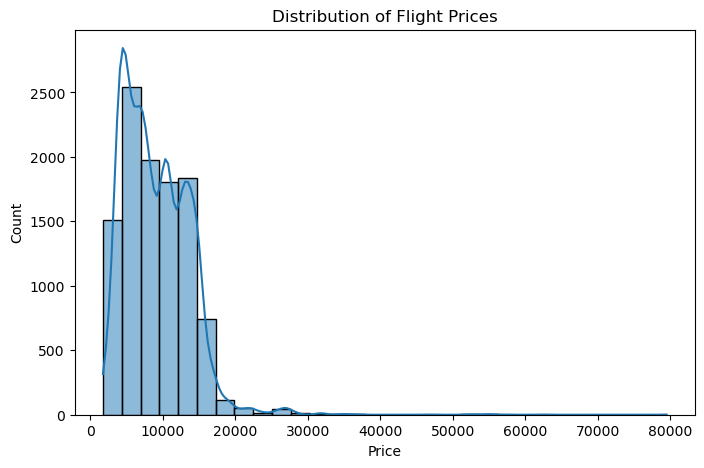

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(flight_data['Price'], kde=True, bins=30)
plt.title('Distribution of Flight Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

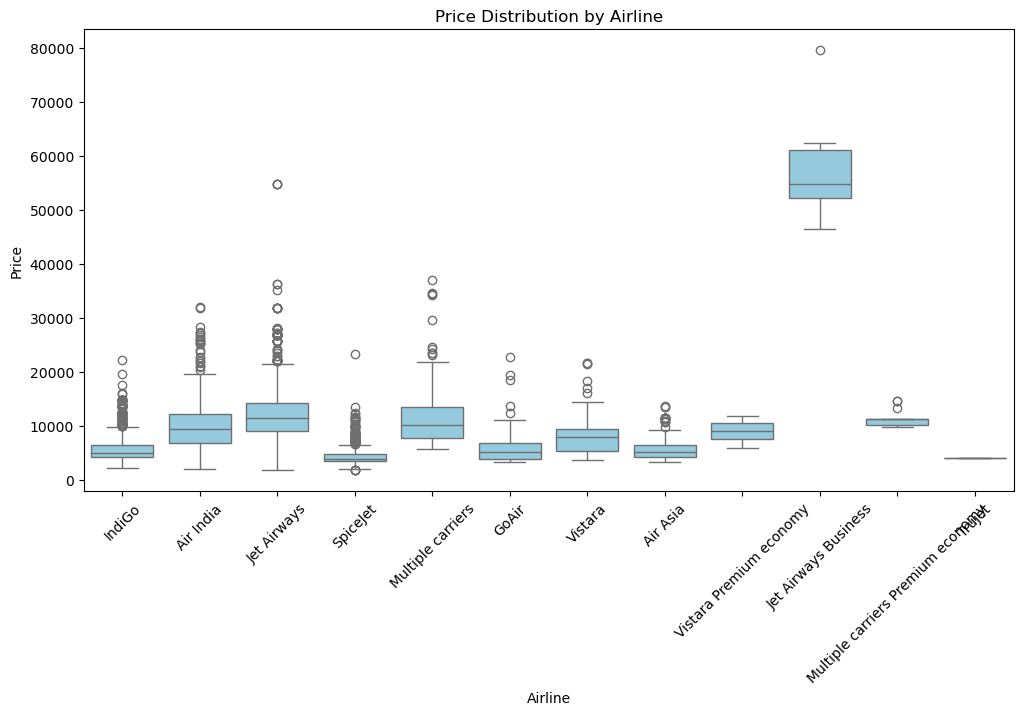

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Airline', y='Price', data=flight_data, color= 'skyblue')
plt.title('Price Distribution by Airline')
plt.xticks(rotation=45)
plt.show()

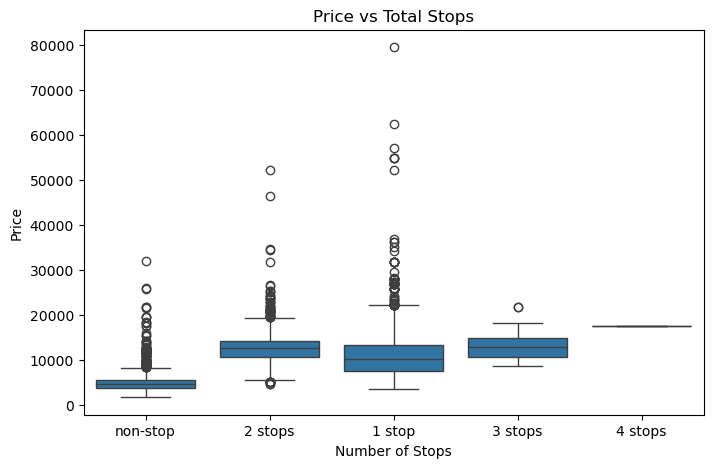

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Total_Stops', y='Price', data=flight_data)
plt.title('Price vs Total Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Price')
plt.show()

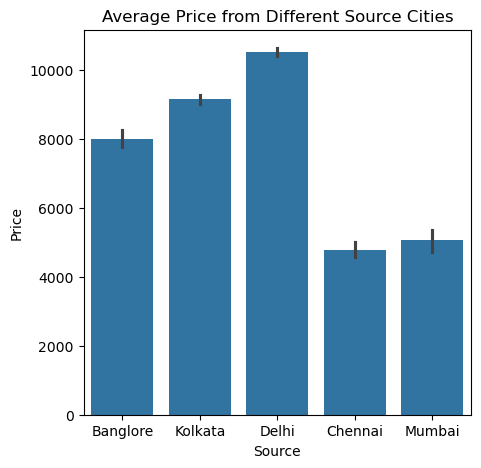

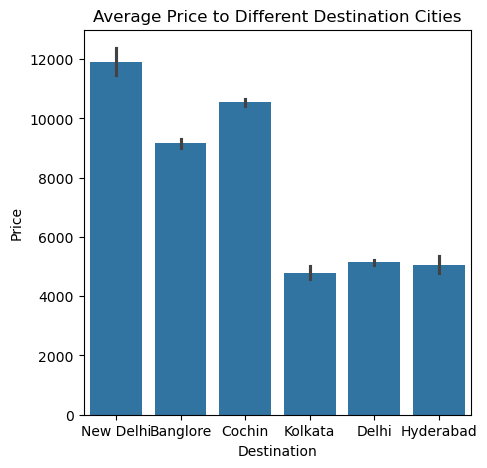

In [19]:
plt.figure(figsize=(5, 5))
sns.barplot(x='Source', y='Price', data=flight_data)
plt.title('Average Price from Different Source Cities')
plt.show()

plt.figure(figsize=(5, 5))
sns.barplot(x='Destination', y='Price', data=flight_data)
plt.title('Average Price to Different Destination Cities')
plt.show()

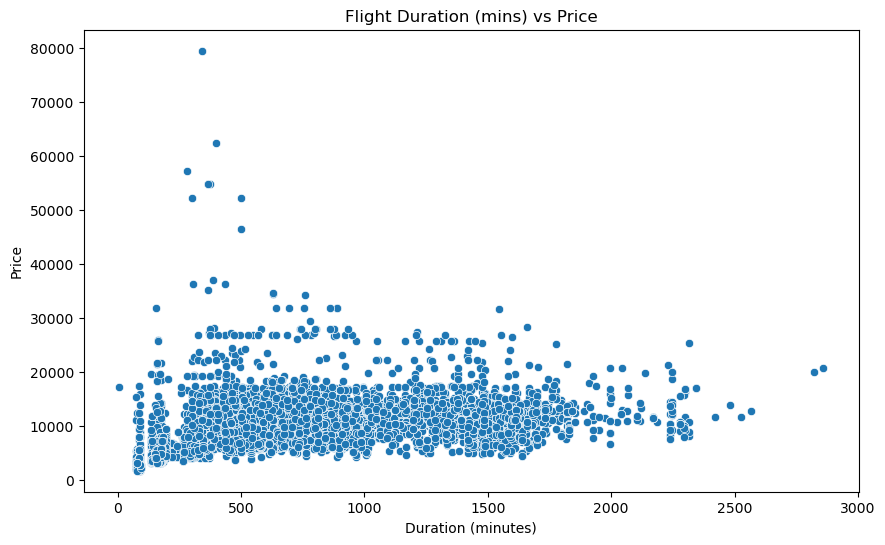

In [21]:
def duration_to_minutes(duration):
    h = m = 0
    h_match = re.search(r'(\d+)h', duration)
    m_match = re.search(r'(\d+)m', duration)
    if h_match:
        h = int(h_match.group(1))
    if m_match:
        m = int(m_match.group(1))
    return h * 60 + m

flight_data['Duration_mins'] = flight_data['Duration'].apply(duration_to_minutes)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration_mins', y='Price', data=flight_data)
plt.title('Flight Duration (mins) vs Price')
plt.xlabel('Duration (minutes)')
plt.ylabel('Price')
plt.show()

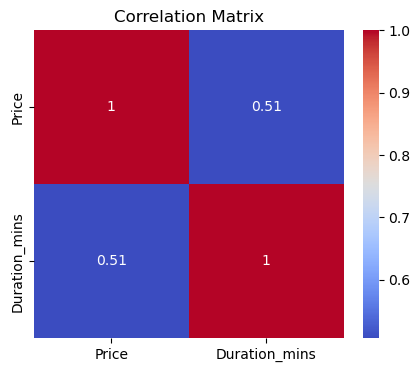

In [26]:
plt.figure(figsize=(5, 4))
sns.heatmap(flight_data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

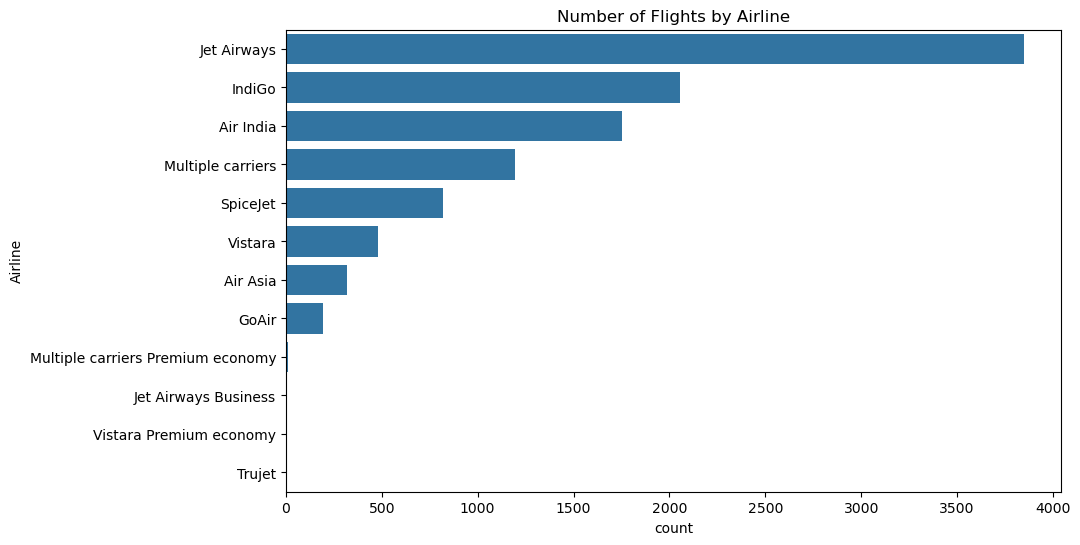

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Airline', data=flight_data, order=flight_data['Airline'].value_counts().index)
plt.title('Number of Flights by Airline')
plt.show()

# Feature engineering

In [27]:
flight_data['Journey_day'] = pd.to_datetime(flight_data['Date_of_Journey'], dayfirst=True).dt.day
flight_data['Journey_month'] = pd.to_datetime(flight_data['Date_of_Journey'], dayfirst=True).dt.month
flight_data.drop('Date_of_Journey', axis=1, inplace=True)

In [28]:
flight_data['Dep_hour'] = pd.to_datetime(flight_data['Dep_Time']).dt.hour
flight_data['Dep_min'] = pd.to_datetime(flight_data['Dep_Time']).dt.minute
flight_data.drop(['Dep_Time'], axis=1, inplace=True)

In [29]:
flight_data['Arrival_hour'] = pd.to_datetime(flight_data['Arrival_Time']).dt.hour
flight_data['Arrival_min'] = pd.to_datetime(flight_data['Arrival_Time']).dt.minute
flight_data.drop(['Arrival_Time'], axis=1, inplace=True)

In [30]:
flight_data['Duration'] = flight_data['Duration'].apply(lambda x: x.replace('h', 'h ').replace('m', 'm '))
flight_data['Duration_hour'] = flight_data['Duration'].str.extract('(\d+)h').fillna(0).astype(int)
flight_data['Duration_min'] = flight_data['Duration'].str.extract('(\d+)m').fillna(0).astype(int)
flight_data['Duration_total_mins'] = flight_data['Duration_hour'] * 60 + flight_data['Duration_min']
flight_data.drop(['Duration', 'Duration_hour', 'Duration_min'], axis=1, inplace=True)

In [31]:
flight_data['Total_Stops'] = flight_data['Total_Stops'].replace({
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}).astype(int)

In [33]:
flight_data.drop(['Route'], axis=1, inplace=True)

In [34]:
flight_data.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Duration_mins,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_total_mins
0,IndiGo,Banglore,New Delhi,0,No info,3897,170,24,3,22,20,1,10,170
1,Air India,Kolkata,Banglore,2,No info,7662,445,1,5,5,50,13,15,445
2,Jet Airways,Delhi,Cochin,2,No info,13882,1140,9,6,9,25,4,25,1140
3,IndiGo,Kolkata,Banglore,1,No info,6218,325,12,5,18,5,23,30,325
4,IndiGo,Banglore,New Delhi,1,No info,13302,285,1,3,16,50,21,35,285


In [35]:
# flight_data.to_csv(r"/Users/purandarakashyap/Documents/ML, Python and projects/ML Projects/flight_data.csv")

In [37]:
cat_cols = ['Airline', 'Source', 'Destination', 'Additional_Info']
le = LabelEncoder()
for col in cat_cols:
    flight_data[col] = le.fit_transform(flight_data[col])

In [38]:
flight_data.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Duration_mins,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_total_mins
0,3,0,5,0,8,3897,170,24,3,22,20,1,10,170
1,1,3,0,2,8,7662,445,1,5,5,50,13,15,445
2,4,2,1,2,8,13882,1140,9,6,9,25,4,25,1140
3,3,3,0,1,8,6218,325,12,5,18,5,23,30,325
4,3,0,5,1,8,13302,285,1,3,16,50,21,35,285


In [39]:
flight_data.describe().T.style.background_gradient(axis= 0)

,count,mean,std,min,25%,50%,75%,max
Airline,10683.000000,3.965927,2.352155,0.000000,3.000000,4.000000,4.000000,11.000000
Source,10683.000000,1.952261,1.177221,0.000000,2.000000,2.000000,3.000000,4.000000
Destination,10683.000000,1.436113,1.474782,0.000000,0.000000,1.000000,2.000000,5.000000
Total_Stops,10683.000000,0.824207,0.675199,0.000000,0.000000,1.000000,1.000000,4.000000
Additional_Info,10683.000000,7.393054,1.214211,0.000000,8.000000,8.000000,8.000000,9.000000
Price,10683.000000,9087.064121,4611.359167,1759.000000,5277.000000,8372.000000,12373.000000,79512.000000
Duration_mins,10683.000000,643.093232,507.862001,5.000000,170.000000,520.000000,930.000000,2860.000000
Journey_day,10683.000000,13.508378,8.479277,1.000000,6.000000,12.000000,21.000000,27.000000
Journey_month,10683.000000,4.708602,1.164357,3.000000,3.000000,5.000000,6.000000,6.000000
Dep_hour,10683.000000,12.490686,5.748650,0.000000,8.000000,11.000000,18.000000,23.000000


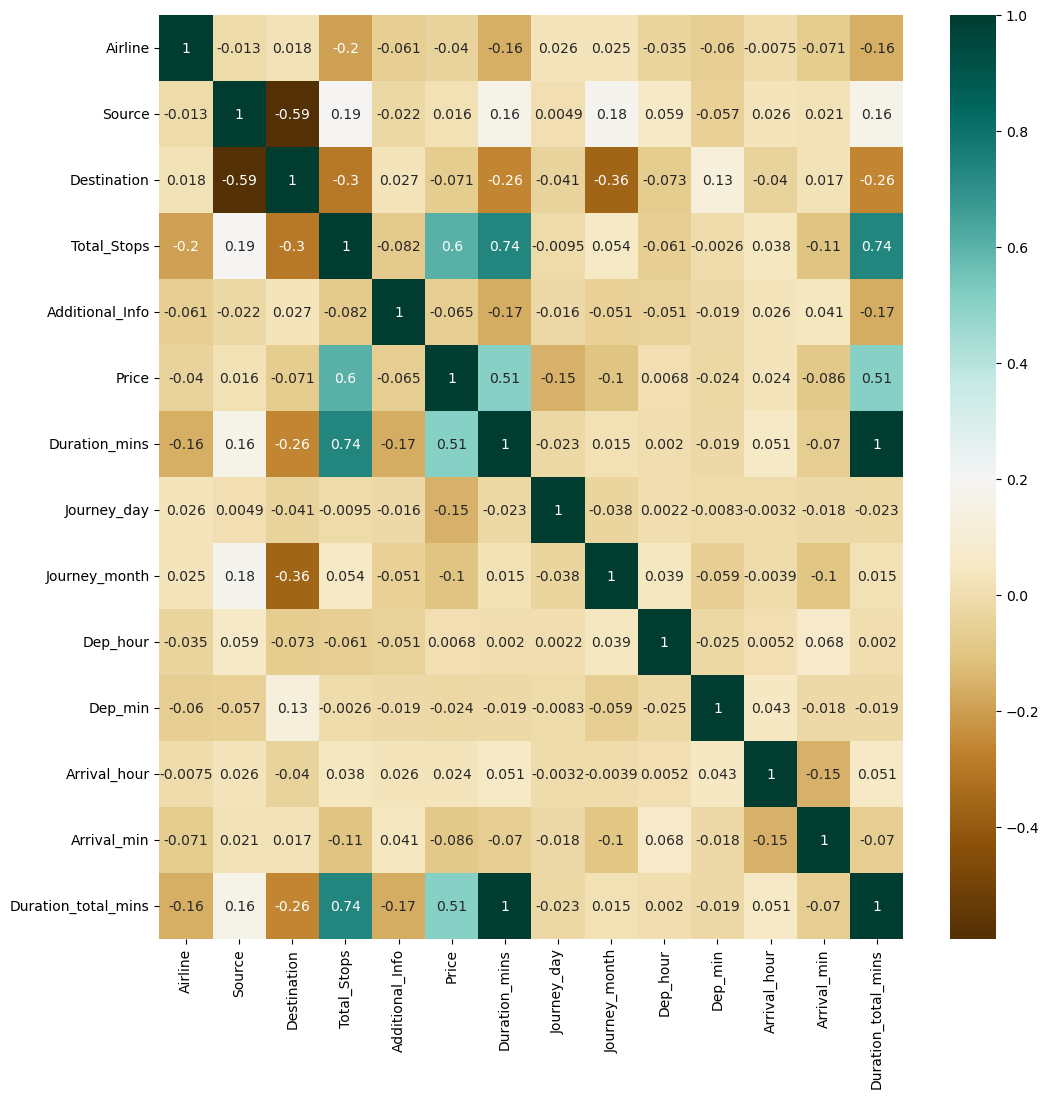

In [40]:
plt.figure(figsize = (12,12))
sns.heatmap(flight_data.corr(),cmap= 'BrBG', annot= True)

plt.show()

# Model building

In [41]:
X = flight_data.drop('Price', axis=1)
y = flight_data['Price']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror'),
    'KNN': KNeighborsRegressor()
}

results = []

for name, model in models.items():
    if name in ['SVR', 'KNN']:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append({'Model': name, 'RMSE': rmse, 'R2 Score': r2})

results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(tabulate(results_df, headers="keys", tablefmt="pretty"))

+---+-------------------+--------------------+----------------------+
|   |       Model       |        RMSE        |       R2 Score       |
+---+-------------------+--------------------+----------------------+
| 7 |      XGBoost      | 1563.7867234626776 |  0.8844531774520874  |
| 6 |   Random Forest   | 1713.218575148128  |  0.861315318758752   |
| 8 |        KNN        | 2047.6646440762477 |  0.8018835182607661  |
| 5 |   Decision Tree   | 2157.997931892524  |  0.779958299791236   |
| 1 |       Ridge       | 3475.0120574226494 |  0.4294212735239258  |
| 2 |       Lasso       | 3475.0324939940083 | 0.42941456234885356  |
| 0 | Linear Regression | 3475.146347435712  | 0.42937717324231883  |
| 3 |    ElasticNet     | 3678.5024126342714 |  0.360640630203404   |
| 4 |        SVR        | 4508.250669965915  | 0.039673185556191926 |
+---+-------------------+--------------------+----------------------+


# Summary
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| Rank | Model                                 | RMSE        | R² Score  | Interpretation                                                                                               |
| ---- | ------------------------------------- | ----------- | --------- | ------------------------------------------------------------------------------------------------------------ |
| 1    | **XGBoost**                           | **1563.79** | **0.884** | ⭐ Best performing model. Very high explanatory power (88.4%) and lowest prediction error.                    |
| 2    | **Random Forest**                     | 1713.22     | 0.861     | Strong model, slightly behind XGBoost. Performs very well.                                                   |
| 3    | **KNN**                               | 2047.66     | 0.802     | Good performance, but worse than tree-based models. Likely affected by high dimensionality or non-linearity. |
| 4    | **Decision Tree**                     | 2158.00     | 0.780     | Acceptable, but overfits more than ensemble models.                                                          |
| 5-7  | **Ridge / Lasso / Linear Regression** | \~3475      | \~0.429   | Moderate predictive power. Struggles with non-linear relationships.                                          |
| 8    | **ElasticNet**                        | 3678.50     | 0.361     | Worse than Ridge and Lasso. May not have added regularization benefit.                                       |
| 9    | **SVR**                               | 4508.25     | 0.039     | ❌ Poor performance. Likely due to poor scaling or lack of tuning.                                            |


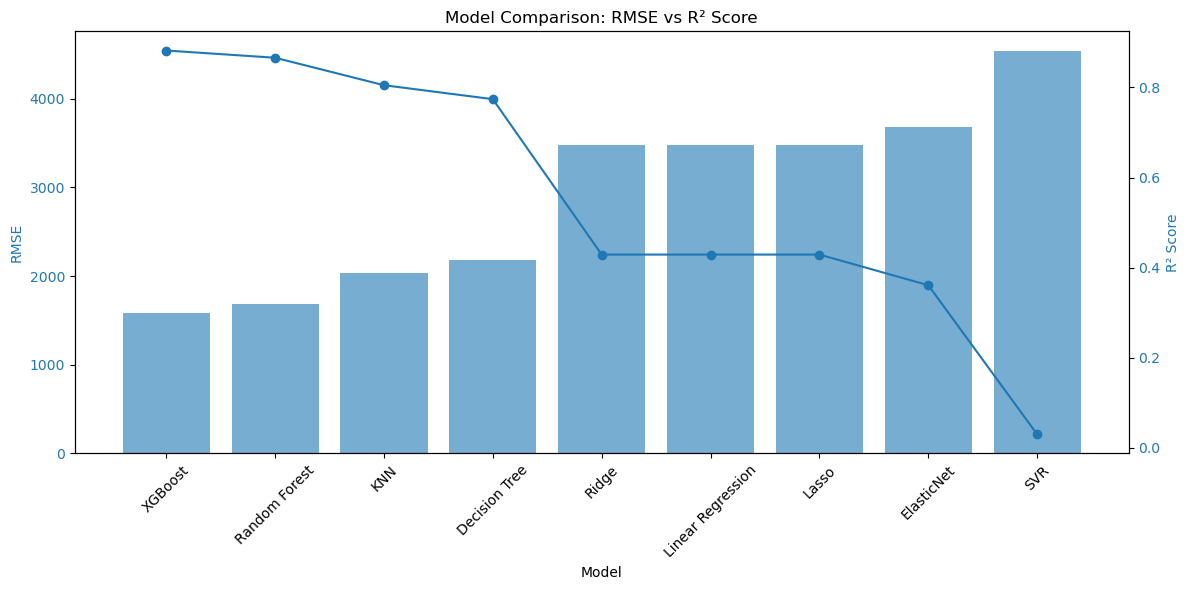

In [48]:
data = {
    'Model': ['XGBoost', 'Random Forest', 'KNN', 'Decision Tree', 'Ridge', 
              'Linear Regression', 'Lasso', 'ElasticNet', 'SVR'],
    'RMSE': [1580.05, 1681.41, 2029.41, 2185.88, 3475.01, 
             3475.01, 3475.03, 3678.50, 4531.18],
    'R2 Score': [0.882, 0.866, 0.805, 0.774, 0.429, 
                 0.429, 0.429, 0.361, 0.030]
}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color=color)
ax1.bar(df['Model'], df['RMSE'], color=color, alpha=0.6, label='RMSE')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('R² Score', color=color)
ax2.plot(df['Model'], df['R2 Score'], color=color, marker='o', label='R² Score')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Model Comparison: RMSE vs R² Score')
fig.tight_layout()
plt.show()

# Note:
During the process of model building and cross validating, the NameError you're seeing (name 'X_scaled' is not defined) means that the scaled version of your input features X_scaled hasn’t been defined yet in your notebook.

Since some models like SVR and KNN are sensitive to feature scales, you need to standardize your data before passing it to them.

# Cross validation

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models_to_validate = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror'),
    'Random Forest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR()
}

results_cv = []

for name, model in models_to_validate.items():
    print(f"🔁 Cross-validating: {name}")
    
    if name in ['SVR', 'KNN']:
        X_used = X_scaled
    else:
        X_used = X

    r2_scores = cross_val_score(model, X_used, y, cv=5, scoring='r2')
    rmse_scores = -cross_val_score(model, X_used, y, cv=5, scoring='neg_root_mean_squared_error')

    results_cv.append({
        'Model': name,
        'Avg R2': np.mean(r2_scores),
        'Std R2': np.std(r2_scores),
        'Avg RMSE': np.mean(rmse_scores),
        'Std RMSE': np.std(rmse_scores)
    })

headers = ['Model', 'Avg R2', 'Std R2', 'Avg RMSE', 'Std RMSE']
print("\n📊 Cross-Validation Results:\n")
print(tabulate(results_cv, headers='keys', floatfmt=".4f", tablefmt="pretty"))

🔁 Cross-validating: XGBoost
🔁 Cross-validating: Random Forest
🔁 Cross-validating: KNN
🔁 Cross-validating: SVR

📊 Cross-Validation Results:

+---------------+---------------------+----------------------+--------------------+--------------------+
|     Model     |       Avg R2        |        Std R2        |      Avg RMSE      |      Std RMSE      |
+---------------+---------------------+----------------------+--------------------+--------------------+
|    XGBoost    | 0.8810697078704834  | 0.019495662911025346 | 1584.7161044481409 | 140.55649604090587 |
| Random Forest |  0.878115270933014  | 0.014935104032323065 | 1601.1924957422307 | 127.5910695460508  |
|      KNN      | 0.7730258498033071  | 0.01700554342781999  | 2195.767197076256  | 129.86039181272614 |
|      SVR      | 0.04412458148782936 | 0.009812954609295736 | 4506.227630257386  | 130.33028758941003 |
+---------------+---------------------+----------------------+--------------------+--------------------+


# Summary

1. XGBoost
* Avg R²: 0.881 — Explains ~88.1% of the variance in prices on average.
* Avg RMSE: 1584.72 — Lowest error among all models.
* Conclusion: ⭐ Best overall model — strong accuracy, low variability.

2. Random Forest
* Avg R²: 0.878 — Very close to XGBoost.
* Avg RMSE: 1601.19 — Slightly higher error than XGBoost.
* Conclusion: 🌟 Excellent model — very stable with low standard deviation.

3. K-Nearest Neighbors (KNN)
* Avg R²: 0.773 — Decent performance but weaker than ensemble models.
* Avg RMSE: 2195.77 — Much higher prediction error.
* Conclusion: ⚠️ Moderate performance — likely struggles with high dimensionality or noise.

4. Support Vector Regressor (SVR)
* Avg R²: 0.044 — Explains only ~4.4% of price variance.
* Avg RMSE: 4506.23 — Extremely high prediction error.
* Conclusion: ❌ Poor performance — SVR is not suitable for this dataset without further tuning or kernel selection.

-------------------------------------------------------------
| Rank | Model             | Verdict                          |
| ---- | ----------------- | -------------------------------- |
| 🥇   | **XGBoost**       | Best performance overall         |
| 🥈   | **Random Forest** | Nearly as strong and more stable |
| 🥉   | **KNN**           | Acceptable, but lower accuracy   |
| ❌    | **SVR**           | Poor fit for this task           |


# Recommendation system

In [61]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

print("📊 XGBoost Prediction Results:")
print(f"✅ RMSE: {xgb_rmse:.2f}")
print(f"✅ R² Score: {xgb_r2:.4f}")

X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

results_df = X_test_reset[['Airline', 'Source', 'Destination', 'Total_Stops']].copy()
results_df['Actual Price'] = y_test_reset
results_df['Predicted Price'] = xgb_preds
results_df['Absolute Error'] = abs(results_df['Actual Price'] - results_df['Predicted Price'])

print("\n📦 Sample Predictions with Contextual Features:")
print(tabulate(results_df.head(10), headers='keys', floatfmt=".2f", tablefmt="pretty"))

📊 XGBoost Prediction Results:
✅ RMSE: 1563.79
✅ R² Score: 0.8845

📦 Sample Predictions with Contextual Features:
+---+---------+--------+-------------+-------------+--------------+-------------------+------------------+
|   | Airline | Source | Destination | Total_Stops | Actual Price |  Predicted Price  |  Absolute Error  |
+---+---------+--------+-------------+-------------+--------------+-------------------+------------------+
| 0 |   4.0   |  3.0   |     0.0     |     1.0     |   10844.0    |  11145.708984375  |  301.708984375   |
| 1 |   2.0   |  2.0   |     1.0     |     1.0     |    4959.0    | 5481.57568359375  | 522.57568359375  |
| 2 |   4.0   |  3.0   |     0.0     |     1.0     |   14781.0    |  15016.455078125  |  235.455078125   |
| 3 |   3.0   |  1.0   |     4.0     |     0.0     |    3858.0    | 3700.70068359375  | 157.29931640625  |
| 4 |   4.0   |  2.0   |     1.0     |     1.0     |   12898.0    | 12074.7314453125  |  823.2685546875  |
| 5 |   6.0   |  2.0   |     1.

# Graphical insights

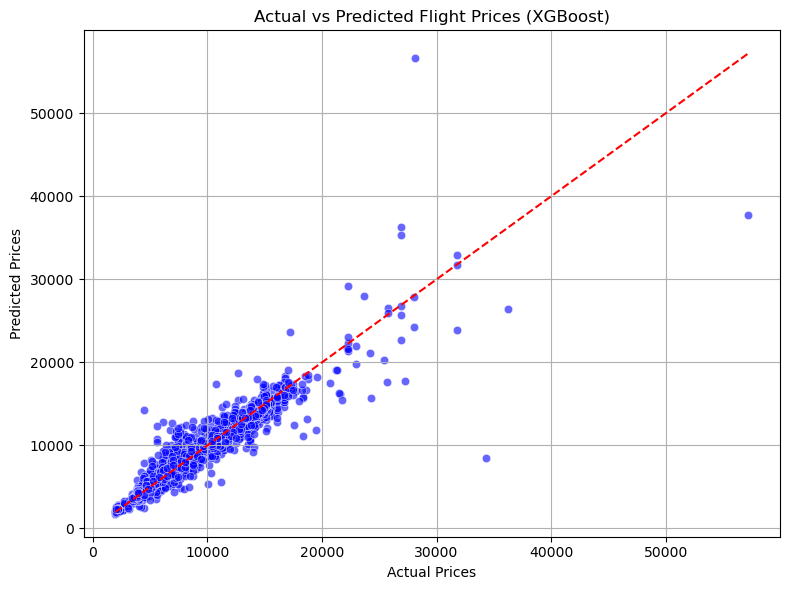

In [51]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=xgb_preds, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Flight Prices (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

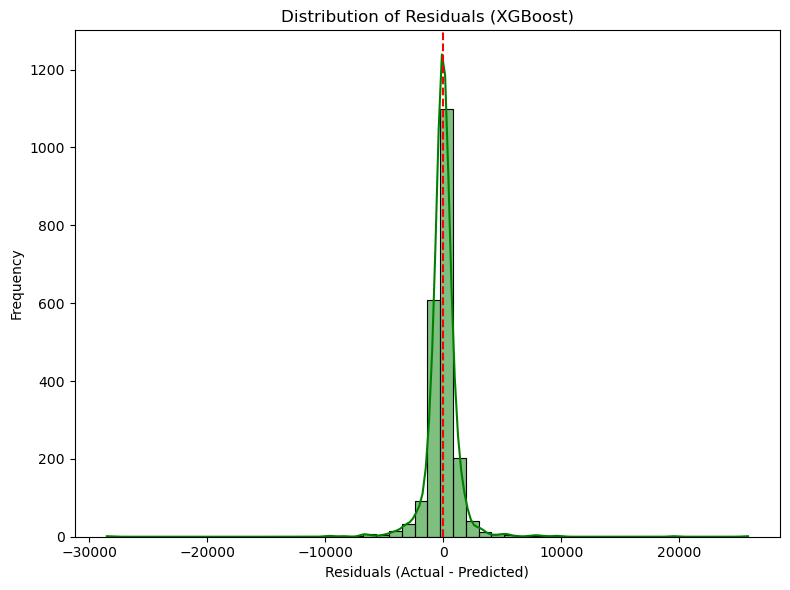

In [52]:
residuals = y_test - xgb_preds
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color="green")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals (XGBoost)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

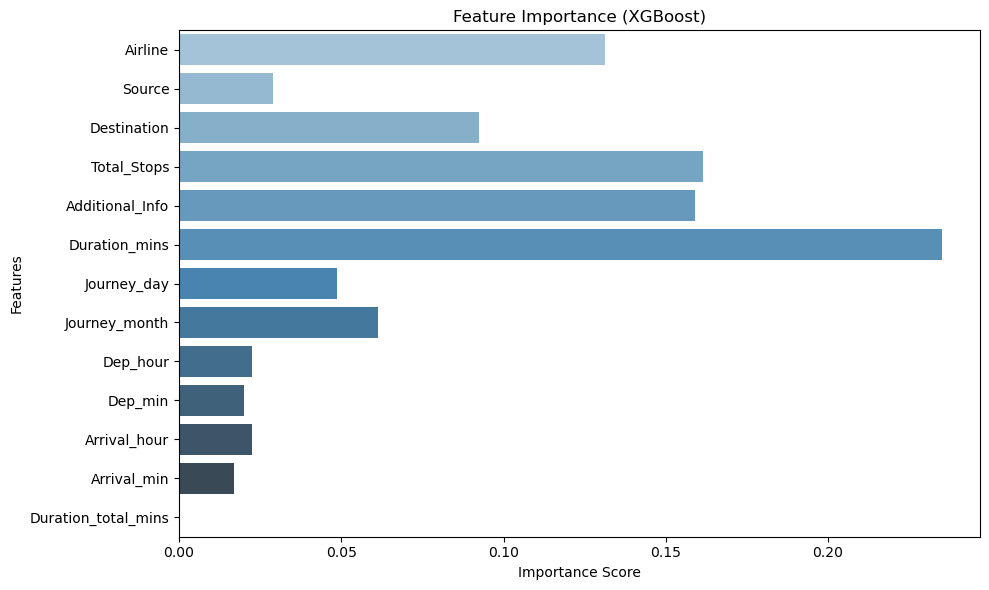

In [53]:
importances = xgb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette='Blues_d')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# The end